In [1]:
%matplotlib inline
import sys
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from collections import defaultdict
import operator
np.set_printoptions(suppress=True)
# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

# from fastdtw import fastdtw
from dtaidistance import dtw
from scipy.spatial.distance import euclidean
from tqdm import tqdm
import csv

from sklearn.manifold import MDS, LocallyLinearEmbedding, Isomap, TSNE

In [2]:
data = pd.read_csv('C:/Users/maria/OneDrive/Desktop/Smart_Meter_Data/New2.txt', sep=" ")

In [3]:
df = data[(data.id == 1003)]
df['date'] = pd.to_datetime(df['date'], format='%d-%m-%y')
# df['month'] = pd.DatetimeIndex(df['date']).month
# df['week']= np.ceil((df['day']-200)/7).astype(int)
df.drop(df[df.day==452].index, inplace=True)
df

id  demand  day  period  dow  tow  week       date  month
24864  1003   0.396  201       1    1    1     1 2009-07-20      7
24865  1003   0.397  201       2    1    2     1 2009-07-20      7
24866  1003   0.378  201       3    1    3     1 2009-07-20      7
24867  1003   0.288  201       4    1    4     1 2009-07-20      7
24868  1003   0.335  201       5    1    5     1 2009-07-20      7
...     ...     ...  ...     ...  ...  ...   ...        ...    ...
49723  1003   0.752  725      44    7  332    75 2010-12-26     12
49724  1003   0.923  725      45    7  333    75 2010-12-26     12
49725  1003   0.865  725      46    7  334    75 2010-12-26     12
49726  1003   0.653  725      47    7  335    75 2010-12-26     12
49727  1003   0.513  725      48    7  336    75 2010-12-26     12

[24864 rows x 9 columns]

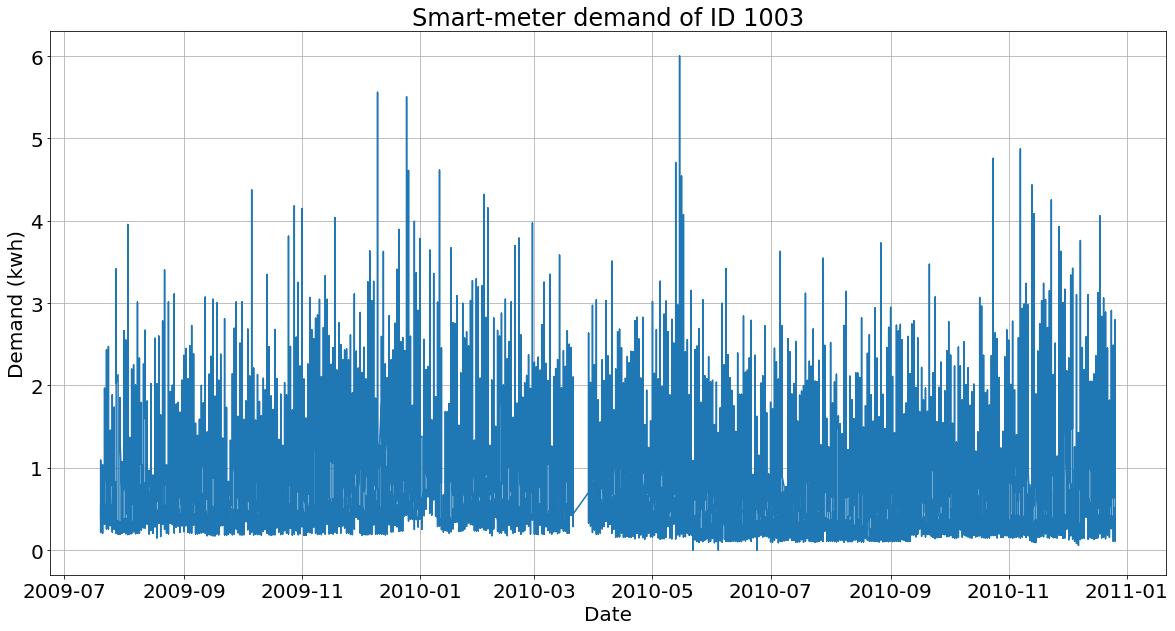

In [4]:
plt.rcParams.update({'font.size': 20})
plt.figure(figsize=(20, 10))
plt.plot(df["date"], df["demand"])
plt.xlabel('Date')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of ID '+str(df.id.unique()[0]))
plt.grid()
plt.show()

# Observation as a daily distribution

In [5]:
df1 = df.groupby(['id','day','date','dow','month']).demand.apply(np.array).reset_index()
df1

id  day       date  dow  month  \
0    1003  201 2009-07-20    1      7   
1    1003  202 2009-07-21    2      7   
2    1003  203 2009-07-22    3      7   
3    1003  204 2009-07-23    4      7   
4    1003  205 2009-07-24    5      7   
..    ...  ...        ...  ...    ...   
513  1003  721 2010-12-22    3     12   
514  1003  722 2010-12-23    4     12   
515  1003  723 2010-12-24    5     12   
516  1003  724 2010-12-25    6     12   
517  1003  725 2010-12-26    7     12   

                                                demand  
0    [0.396, 0.397, 0.378, 0.288, 0.335, 0.407, 0.3...  
1    [0.509, 0.594, 0.629, 0.64, 0.593, 0.499, 0.5,...  
2    [0.83, 1.078, 0.51, 0.314, 0.355, 0.42, 0.421,...  
3    [0.551, 0.541, 0.532, 0.356, 0.309, 0.33, 0.43...  
4    [0.409, 0.443, 0.531, 0.528, 0.443, 0.402, 0.4...  
..                                                 ...  
513  [0.75, 0.916, 0.658, 0.33, 0.441, 0.457, 0.342...  
514  [0.897, 0.526, 0.336, 0.206, 0.366, 0.247, 0.3...  
515  [0.848, 0.871, 0.851, 1.018, 0.883, 0.867, 0.6...  
516  [0.37, 0.352, 0.241, 0.212, 0.148, 0.16, 0.212...  
517  [0.652, 0.718, 0.632, 0.319, 0.325, 0.448, 0.3...  

[518 rows x 6 columns]

In [6]:
dd_v1 = df1['demand'].to_numpy()
dd_arr1 = np.vstack(dd_v1)
print(dd_arr1.shape)
color_arr1 = df1['month'].to_numpy() # map to month
print(color_arr1.shape)
color_arr2 = df1['dow'].to_numpy() # map to day of week
print(color_arr2.shape)

(518, 48)
(518,)
(518,)


In [7]:
dd_v1[0]

array([0.396, 0.397, 0.378, 0.288, 0.335, 0.407, 0.397, 0.398, 0.397,
       0.764, 0.57 , 0.362, 0.273, 0.273, 0.333, 0.505, 0.565, 0.553,
       0.611, 0.558, 0.66 , 0.804, 0.605, 0.852, 0.555, 0.492, 0.497,
       0.547, 0.846, 0.539, 0.266, 0.214, 0.274, 0.328, 0.319, 0.317,
       0.576, 1.092, 0.522, 0.461, 0.496, 0.571, 0.599, 0.598, 0.844,
       0.621, 0.621, 0.54 ])

In [8]:
dtw_matrix10 = dtw.distance_matrix_fast(dd_arr1)

In [9]:
dtw_matrix11 = dtw.distance_matrix_fast(dd_arr1,window=24)

In [10]:
dtw_matrix12 = dtw.distance_matrix_fast(dd_arr1,psi=2)
dtw_matrix13 = dtw.distance_matrix_fast(dd_arr1,psi=4)
dtw_matrix14 = dtw.distance_matrix_fast(dd_arr1,window=24,psi=2)
dtw_matrix15 = dtw.distance_matrix_fast(dd_arr1,window=24,psi=4)

## Colormap setting (color corresponding to seasons)

In [11]:
import matplotlib.colors
from matplotlib.colors import ListedColormap
def plotscatter(xdata,ydata,color_array,mapping_type="season"):
    '''Modified from reference https://stackoverflow.com/questions/14777066/matplotlib-discrete-colorbar,
    answer by author Enzoupi. Colors map to seasons in Ireland:
    green-spring
    yellow-summer
    red-autumn
    blue-winter'''
    
    if mapping_type == "season":
        col_dict={1:"blue",
              2:"royalblue",
              3:"darkgreen",
              4:"forestgreen",
              5:"limegreen",
              6:"lemonchiffon",
              7:"khaki",
              8:"gold",          
              9:"orangered",          
              10:"red",
              11:"darkred",
              12:"darkblue"
             }
    elif mapping_type == "day":
        col_dict={1:"red",
              2:"orange",
              3:"yellow",
              4:"green",
              5:"blue",
              6:"indigo",
              7:"purple"
                }
        


    # We create a colormar from our list of colors
    cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])
    labels = np.array(list(col_dict.keys()))
    len_lab = len(labels)
    # prepare normalizer
    ## Prepare bins for the normalizer
    norm_bins = np.sort([*col_dict.keys()]) + 0.5
    norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
    ## Make normalizer and formatter
    norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
    fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
    diff = norm_bins[1:] - norm_bins[:-1]
    tickz = norm_bins[:-1] + diff / 2

    plt.scatter(xdata,ydata,c = color_array, cmap=cmap, norm=norm)
    plt.colorbar(format=fmt, ticks=tickz)
    plt.axis('equal')
#     plt.show()

## MDS

### Using Euclidean distance

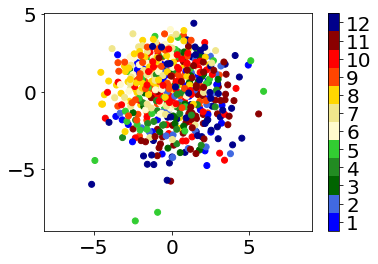

In [12]:
model_MDS = MDS(n_components=2, random_state=1)
out_MDS1 = model_MDS.fit_transform(dd_arr1)
plotscatter(out_MDS1[:, 0], out_MDS1[:, 1],color_arr1)

### Using Dynamic Time Warping (DTW)

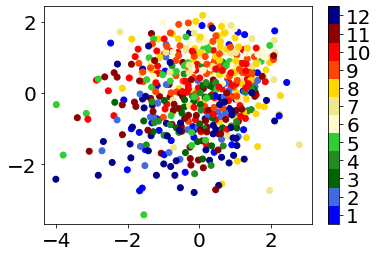

In [13]:
model_MDS = MDS(n_components=2,dissimilarity='precomputed', random_state=1)
out_MDS20 = model_MDS.fit_transform(dtw_matrix10)
out_MDS21 = model_MDS.fit_transform(dtw_matrix11)
out_MDS22 = model_MDS.fit_transform(dtw_matrix12)
out_MDS23 = model_MDS.fit_transform(dtw_matrix13)
out_MDS24 = model_MDS.fit_transform(dtw_matrix14)
out_MDS25 = model_MDS.fit_transform(dtw_matrix15)
plotscatter(out_MDS20[:, 0], out_MDS20[:, 1],color_arr1)

### Comparison

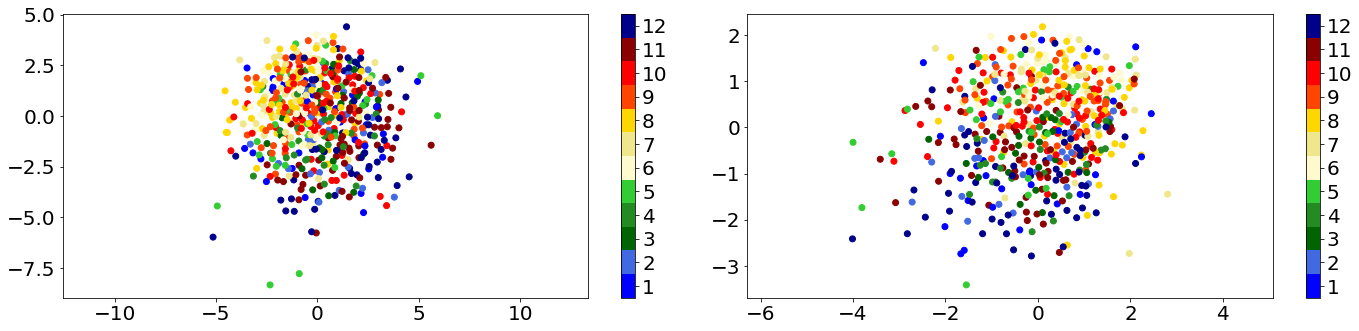

In [14]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_MDS1[:, 0], out_MDS1[:, 1],color_arr1)

plt.subplot(1, 2, 2)
plotscatter(out_MDS20[:, 0], out_MDS20[:, 1],color_arr1)


plt.tight_layout()

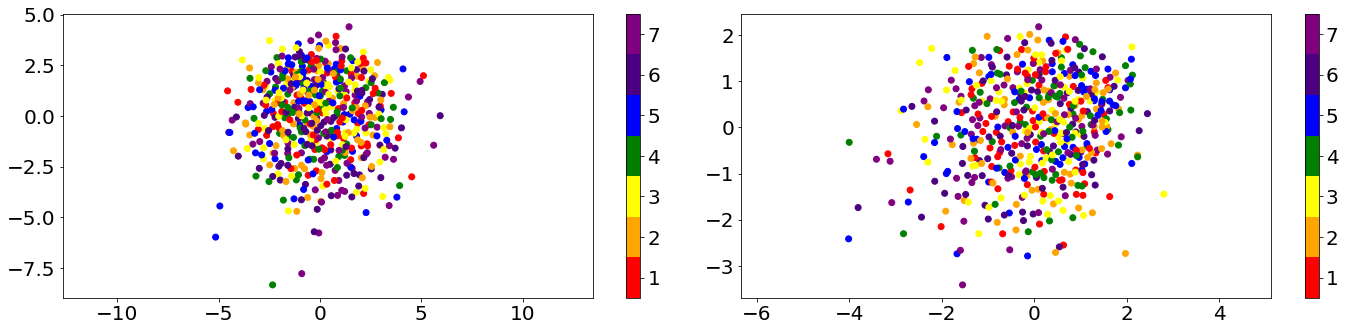

In [15]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_MDS1[:, 0], out_MDS1[:, 1],color_arr2,mapping_type="day")

plt.subplot(1, 2, 2)
plotscatter(out_MDS20[:, 0], out_MDS20[:, 1],color_arr2,mapping_type="day")


plt.tight_layout()

## Isomap

### Using Euclidean distance

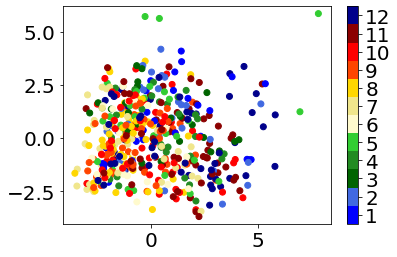

In [16]:
model_Isomap = Isomap(n_neighbors=20, n_components=2, eigen_solver='dense')
out_Isomap1 = model_Isomap.fit_transform(dd_arr1)

plotscatter(out_Isomap1[:, 0], out_Isomap1[:, 1], color_arr1)

### Using Dynamic Time Warping (DTW)

In [120]:
# model_Isomap = Isomap(n_neighbors=5, n_components=2,metric='percomputed')
# out_Isomap2 = model_Isomap.fit_transform(dtw_matrix1)

# plt.scatter(out_Isomap2[:, 0], out_Isomap2[:, 1], c=color_arr1,  cmap=cmap, norm=norm)
# plt.colorbar(ticks=tickz)
# plt.axis('equal')

In [17]:
def distance_mat(X, window=None, psi=None, n_neighbors=6):
    """
    Compute the square distance matrix using DTW
    :param X: Input data, a numpy array of shape (img_height, img_width)
    :param n_neighbors: Number of nearest neighbors to consider, int
    :return: numpy array of shape (img_height, img_height), numpy array of shape (img_height, n_neighbors)
    """

    # Compute full distance matrix
    distances = dtw.distance_matrix_fast(X, window=window,psi=psi)

    # Keep only the 6 nearest neighbors, others set to 0 (= unreachable)
    neighbors = np.zeros_like(distances)
    sort_distances = np.argsort(distances, axis=1)[:, 1:n_neighbors+1]
    for k,i in enumerate(sort_distances):
        neighbors[k,i] = distances[k,i]
    return neighbors, sort_distances

In [18]:
def center(K):
    """
    Method to center the distance matrix
    :param K: numpy array of shape mxm
    :return: numpy array of shape mxm
    """
    n_samples = K.shape[0]

    # Mean for each row/column
    meanrows = np.sum(K, axis=0) / n_samples
    meancols = (np.sum(K, axis=1)/n_samples)[:, np.newaxis]

    # Mean across all rows (entire matrix)
    meanall = meanrows.sum() / n_samples

    K -= meanrows
    K -= meancols
    K += meanall
    return K

In [19]:
def mds(data, n_components=2):
    """
    Apply multidimensional scaling (aka Principal Coordinates Analysis)
    :param data: nxn square distance matrix
    :param n_components: number of components for projection
    :return: projected output of shape (n_components, n)
    """

    # Center distance matrix
    center(data)
    
    # Make a list of (eigenvalue, eigenvector) tuples
    eig_val_cov, eig_vec_cov = np.linalg.eig(data)
    eig_pairs = [
        (np.abs(eig_val_cov[i]), eig_vec_cov[:, i]) for i in range(len(eig_val_cov))
    ]
    
    # Select n_components eigenvectors with largest eigenvalues, obtain subspace transform matrix
    eig_pairs.sort(key=lambda x: x[0], reverse=True)
    eig_pairs = np.array(eig_pairs)
    matrix_w = np.hstack(
        [eig_pairs[i, 1].reshape(data.shape[1], 1) for i in range(n_components)]
    )

    # Return samples in new subspace
    return matrix_w

In [20]:
def isomap(data,window=None,psi=None,n_components=2, n_neighbors=6):
    """
    Dimensionality reduction with isomap algorithm
    :param data: input image matrix of shape (n,m) if dist=False, square distance matrix of size (n,n) if dist=True
    :param n_components: number of components for projection
    :param n_neighbors: number of neighbors for distance matrix computation
    :return: Projected output of shape (n_components, n)
    """
    # Compute distance matrix
    data, _ = distance_mat(data, window,psi, n_neighbors)

    # Compute shortest paths from distance matrix
    from sklearn.utils.graph import graph_shortest_path
    graph = graph_shortest_path(data, directed=False)
    graph = -0.5 * (graph ** 2)

    # Return the MDS projection on the shortest paths graph
    return mds(graph, n_components)

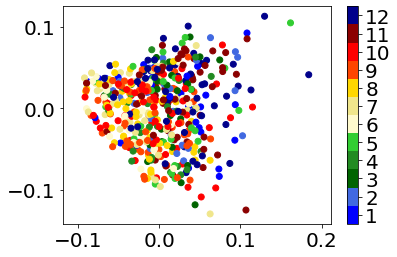

In [21]:
from dtaidistance import dtw
scratch_Isomap20 = isomap(dd_arr1,n_neighbors=20)
scratch_Isomap21 = isomap(dd_arr1,window= 24,n_neighbors=20)
scratch_Isomap22 = isomap(dd_arr1,psi= 2,n_neighbors=20)
scratch_Isomap23 = isomap(dd_arr1,psi= 4,n_neighbors=20)
scratch_Isomap24 = isomap(dd_arr1,window= 24,psi= 2,n_neighbors=20)
scratch_Isomap25 = isomap(dd_arr1,window= 24,psi= 4,n_neighbors=20)
plotscatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],color_arr1)

### Comparison

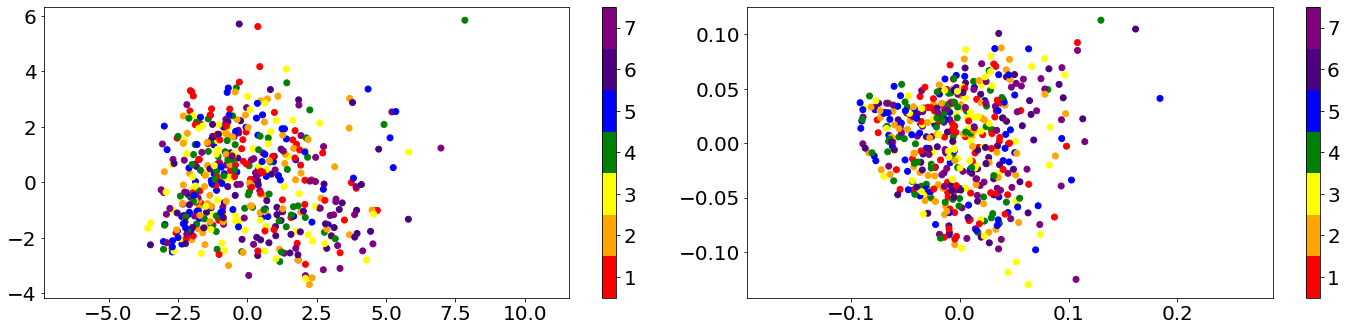

In [22]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_Isomap1[:, 0], out_Isomap1[:, 1], color_arr2,mapping_type="day")

plt.subplot(1, 2, 2)
plotscatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],color_arr2,mapping_type="day")

plt.tight_layout()

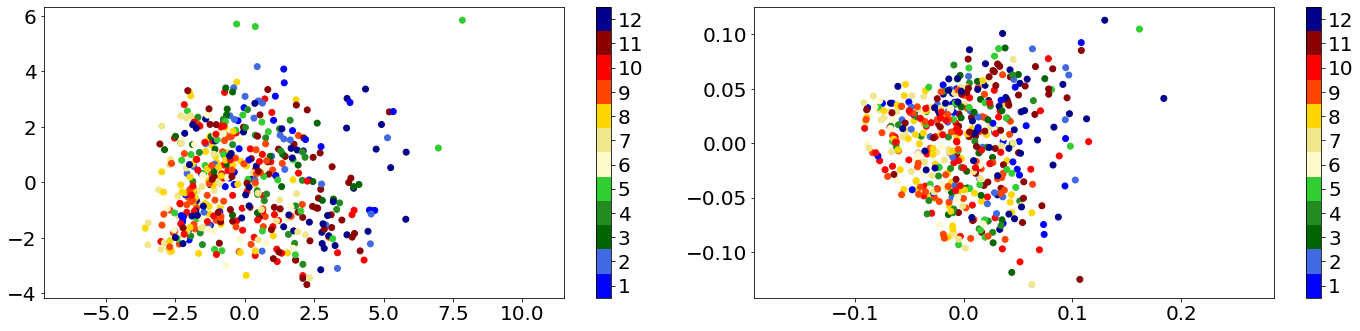

In [23]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plotscatter(out_Isomap1[:, 0], out_Isomap1[:, 1], color_arr1)

plt.subplot(1, 2, 2)
plotscatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],color_arr1)

plt.tight_layout()

In [24]:
col_dict={1:"blue",
              2:"royalblue",
              3:"darkgreen",
              4:"forestgreen",
              5:"limegreen",
              6:"lemonchiffon",
              7:"khaki",
              8:"gold",          
              9:"orangered",          
              10:"red",
              11:"darkred",
              12:"darkblue"
             }
# We create a colormar from our list of colors
cmap = ListedColormap([col_dict[x] for x in col_dict.keys()])
labels = np.array(list(col_dict.keys()))
len_lab = len(labels)
# prepare normalizer
## Prepare bins for the normalizer
norm_bins = np.sort([*col_dict.keys()]) + 0.5
norm_bins = np.insert(norm_bins, 0, np.min(norm_bins) - 1.0)
## Make normalizer and formatter
norm = matplotlib.colors.BoundaryNorm(norm_bins, len_lab, clip=True)
fmt = matplotlib.ticker.FuncFormatter(lambda x, pos: labels[norm(x)])
diff = norm_bins[1:] - norm_bins[:-1]
tickz = norm_bins[:-1] + diff / 2

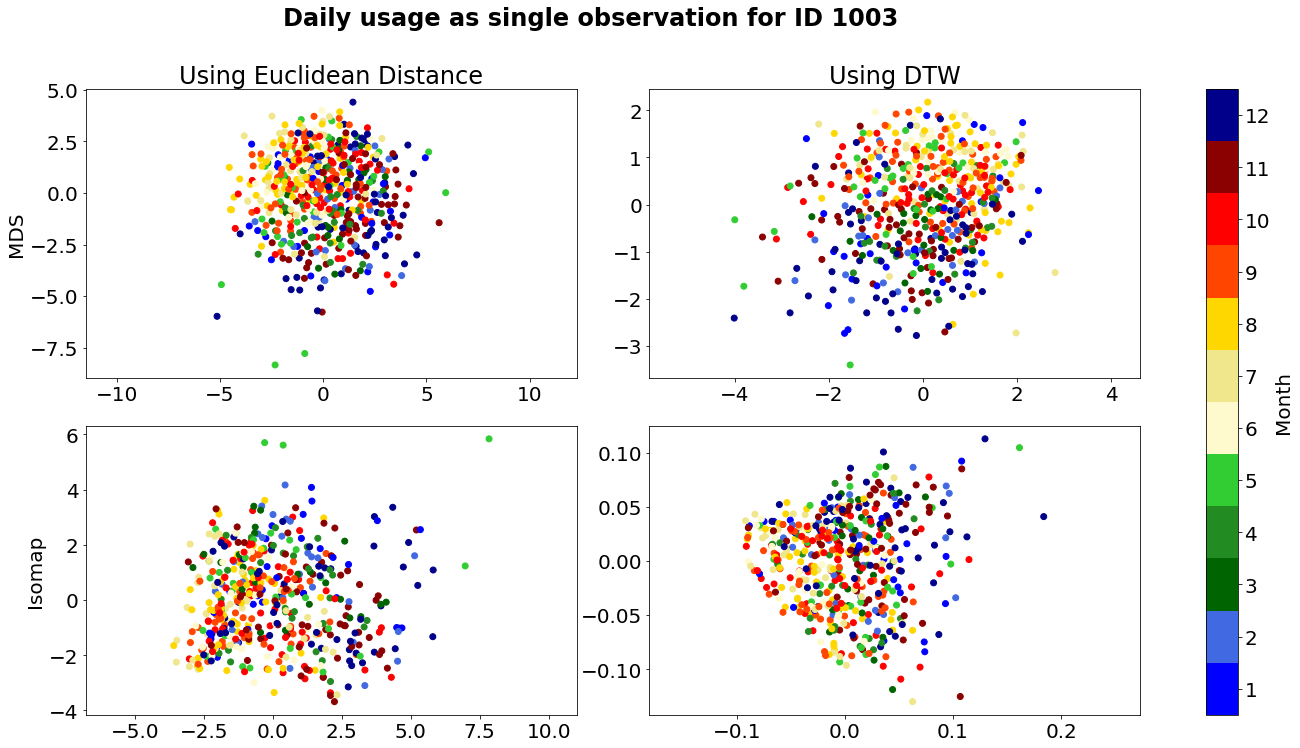

In [25]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
((ax1, ax2),(ax3, ax4))=axs

ax1.scatter(out_MDS1[:, 0], out_MDS1[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax1.axis('equal')
ax1.set_title("Using Euclidean Distance")
ax1.set_ylabel("MDS")

ax2.scatter(out_MDS20[:, 0], out_MDS20[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax2.axis('equal')
ax2.set_title("Using DTW")

ax3.scatter(out_Isomap1[:, 0], out_Isomap1[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax3.axis('equal')
ax3.set_ylabel("Isomap")

im = ax4.scatter(scratch_Isomap20[:, 0], scratch_Isomap20[:, 1],c = color_arr1, cmap=cmap, norm=norm)
ax4.axis('equal')

plt.tight_layout()

fig.colorbar(im,ax=axs,label='Month',format=fmt, ticks=tickz)
fig.suptitle("Daily usage as single observation for ID 1003",x=0.42,y=1.05,fontweight="bold")

plt.axis('equal')

plt.show()
fig.savefig('1003daily.png',bbox_inches='tight')

## Use plotly to locate interested observations

In [26]:
def array_to_pd(my_array):
    '''Convert numpy.ndarray into pandas dataframe
    input: (N,2)array
    output: df '''
    df = pd.DataFrame(my_array, columns = ['x','y'])
    return df

In [27]:
import plotly.express as px
df_iso1 = array_to_pd(out_Isomap1)
fig = px.scatter(df_iso1,x="x", y="y",hover_data= [df_iso1.index], color=list(map(str, color_arr1)),
                color_discrete_map={
                "1":"blue",
                "2":"royalblue",
                "3":"darkgreen",
                "4":"forestgreen",
                "5":"limegreen",
                "6":"lemonchiffon",
                "7":"khaki",
                "8":"gold",          
                "9":"orangered",          
                "10":"red",
                "11":"darkred",
                '12':"darkblue"},
                 category_orders={"Month": ["11", "10", "9", "8", "7", "6","5","4","3","2","1","12"]})
fig.show()

In [28]:
df_iso20 = array_to_pd(scratch_Isomap20)
fig = px.scatter(df_iso20,x="x", y="y",hover_data= [df_iso20.index], color=list(map(str, color_arr1)),
                color_discrete_map={
                "1":"blue",
                "2":"royalblue",
                "3":"darkgreen",
                "4":"forestgreen",
                "5":"limegreen",
                "6":"lemonchiffon",
                "7":"khaki",
                "8":"gold",          
                "9":"orangered",          
                "10":"red",
                "11":"darkred",
                '12':"darkblue"},
                 category_orders={"Month": ["11", "10", "9", "8", "7", "6","5","4","3","2","1","12"]})
fig.show()

In [29]:
scratch_Isomap20[110]

array([ 0.01094299, -0.02764672])

In [30]:
df1[df1.index==110]

id  day       date  dow  month  \
110  1003  311 2009-11-07    6     11   

                                                demand  
110  [0.528, 0.47, 0.409, 0.473, 0.528, 0.395, 0.27...

In [31]:
dd_arr1[110]

array([0.528, 0.47 , 0.409, 0.473, 0.528, 0.395, 0.278, 0.402, 0.337,
       0.278, 0.346, 0.39 , 0.295, 0.37 , 0.535, 0.695, 0.517, 0.5  ,
       0.715, 1.033, 0.627, 0.505, 0.594, 0.488, 0.5  , 0.346, 0.484,
       0.506, 0.659, 0.756, 1.806, 1.964, 2.569, 1.083, 1.101, 1.172,
       0.812, 0.815, 2.396, 1.948, 0.754, 0.87 , 0.922, 0.821, 1.086,
       1.473, 1.061, 1.217])

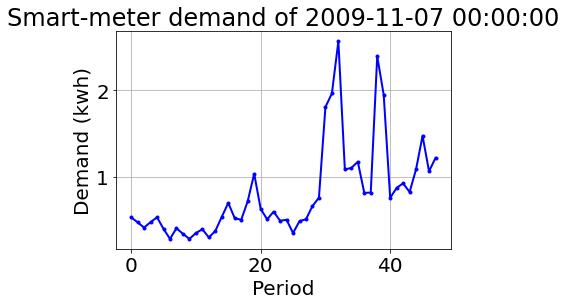

In [32]:
plt.plot(dd_arr1[110], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('Period')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of '+str(df1.date[110]))
plt.grid()
plt.show()

# Observation as a time of week (tow)

In [33]:
# df = data[(data.id == 1049)&(data.day>200)&(data.day<726)] 
df.drop(df[df.week==0].index, inplace=True) # first week started on day 201
df.drop(df[df.week==36].index, inplace=True)# for now delete the week which contains day 452
df.drop(df[df.week==76].index, inplace=True) # last week is week 75
df2 = df.groupby(['dow','period','tow']).demand.apply(np.array).reset_index()
df2

dow  period  tow                                             demand
0      1       1    1  [0.396, 0.791, 0.444, 0.738, 0.512, 0.536, 0.5...
1      1       2    2  [0.397, 0.792, 0.368, 0.612, 0.515, 0.602, 0.4...
2      1       3    3  [0.378, 0.801, 0.336, 0.593, 0.553, 0.592, 0.4...
3      1       4    4  [0.288, 0.812, 0.351, 0.586, 0.623, 0.573, 0.4...
4      1       5    5  [0.335, 0.764, 1.287, 0.586, 0.615, 0.565, 0.3...
..   ...     ...  ...                                                ...
331    7      44  332  [1.381, 0.451, 0.64, 0.675, 0.858, 1.411, 0.93...
332    7      45  333  [1.887, 0.449, 0.729, 0.759, 0.745, 1.07, 0.98...
333    7      46  334  [0.911, 0.461, 0.783, 0.634, 0.626, 0.825, 0.8...
334    7      47  335  [0.796, 0.449, 0.773, 0.614, 0.582, 0.794, 0.5...
335    7      48  336  [0.782, 0.445, 0.796, 0.614, 0.528, 0.669, 0.4...

[336 rows x 4 columns]

In [34]:
dd_v2 = df2['demand'].to_numpy()
dd_arr2 = np.vstack(dd_v2)
print(dd_arr2.shape)
color_arr3 = df2['period'].to_numpy() # map to period
print(color_arr3.shape)

(336, 74)
(336,)


In [35]:
dtw_matrix20 = dtw.distance_matrix_fast(dd_arr2)
dtw_matrix21 = dtw.distance_matrix_fast(dd_arr2,window=24)
dtw_matrix22 = dtw.distance_matrix_fast(dd_arr2,psi=2)
dtw_matrix23 = dtw.distance_matrix_fast(dd_arr2,psi=4)
dtw_matrix24 = dtw.distance_matrix_fast(dd_arr2,window=24,psi=2)
dtw_matrix25 = dtw.distance_matrix_fast(dd_arr2,window=24,psi=4)

## MDS

### Using Euclidean distance

(-9.784489822581023, 7.395437909946237, -6.00054019221961, 10.082091408295339)

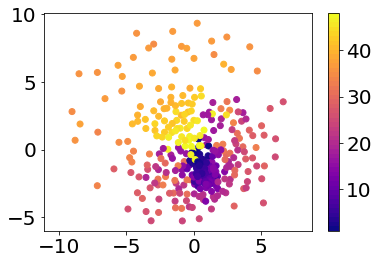

In [36]:
model_MDS = MDS(n_components=2, random_state=1)
out_MDS3 = model_MDS.fit_transform(dd_arr2)
plt.scatter(out_MDS3[:, 0], out_MDS3[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

### Using Dynamic Time Warping (DTW)

(-3.0550615332117195,
 7.021927446028998,
 -6.165103971439963,
 2.9555548994386625)

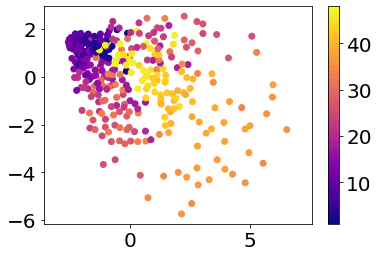

In [37]:
model_MDS = MDS(n_components=2,dissimilarity='precomputed', random_state=1)
out_MDS40 = model_MDS.fit_transform(dtw_matrix20)
out_MDS41 = model_MDS.fit_transform(dtw_matrix21)
out_MDS42 = model_MDS.fit_transform(dtw_matrix22)
out_MDS43 = model_MDS.fit_transform(dtw_matrix23)
out_MDS44 = model_MDS.fit_transform(dtw_matrix24)
out_MDS45 = model_MDS.fit_transform(dtw_matrix25)
plt.scatter(out_MDS40[:, 0], out_MDS40[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

### Comparison

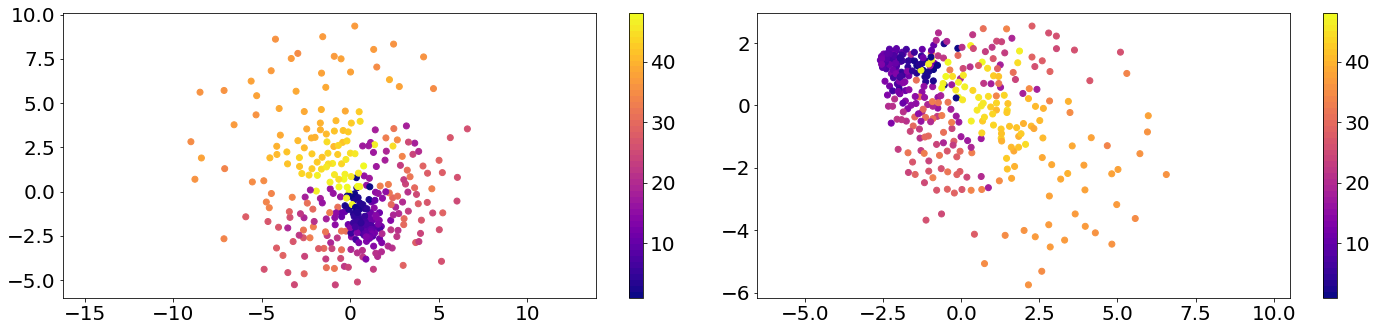

In [38]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(out_MDS3[:, 0], out_MDS3[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(out_MDS40[:, 0], out_MDS40[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.tight_layout()

## Isomap

### Using Euclidean distance

(-5.112377212637357, 9.080844640162352, -5.314862122212149, 5.406209200760173)

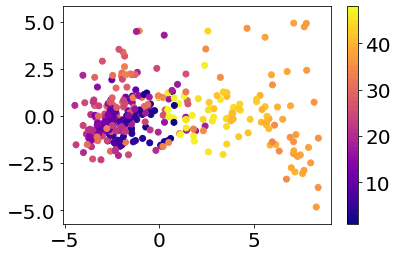

In [39]:
model_Isomap = Isomap(n_neighbors=20, n_components=2, eigen_solver='dense')
out_Isomap3 = model_Isomap.fit_transform(dd_arr2)

plt.scatter(out_Isomap3[:, 0], out_Isomap3[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')
# plt.clim('-0.5, 9.5')

### Using Dynamic Time Warping (DTW)

In [142]:
# model_Isomap = Isomap(n_neighbors=5, n_components=2,metric='percomputed')
# out_Isomap4 = model_Isomap.fit_transform(dtw_matrix2)

# plt.scatter(out_Isomap4[:, 0], out_Isomap4[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
# plt.colorbar()
# plt.axis('equal')

(-0.08290975344894744,
 0.19238414538226464,
 -0.172831744115715,
 0.1291771782063876)

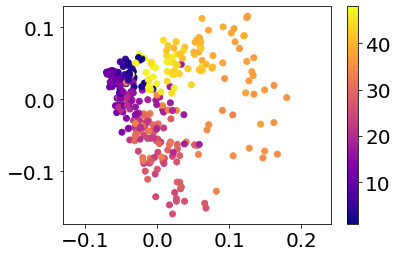

In [40]:
scratch_Isomap40 = isomap(dd_arr2,n_neighbors=20)
scratch_Isomap41 = isomap(dd_arr2,window=24,n_neighbors=20)
scratch_Isomap42 = isomap(dd_arr2,psi=2, n_neighbors=20)
scratch_Isomap43 = isomap(dd_arr2,psi=4, n_neighbors=20)
scratch_Isomap44 = isomap(dd_arr2,window=24,psi=2,n_neighbors=20)
scratch_Isomap45 = isomap(dd_arr2,window=24,psi=4,n_neighbors=20)
plt.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

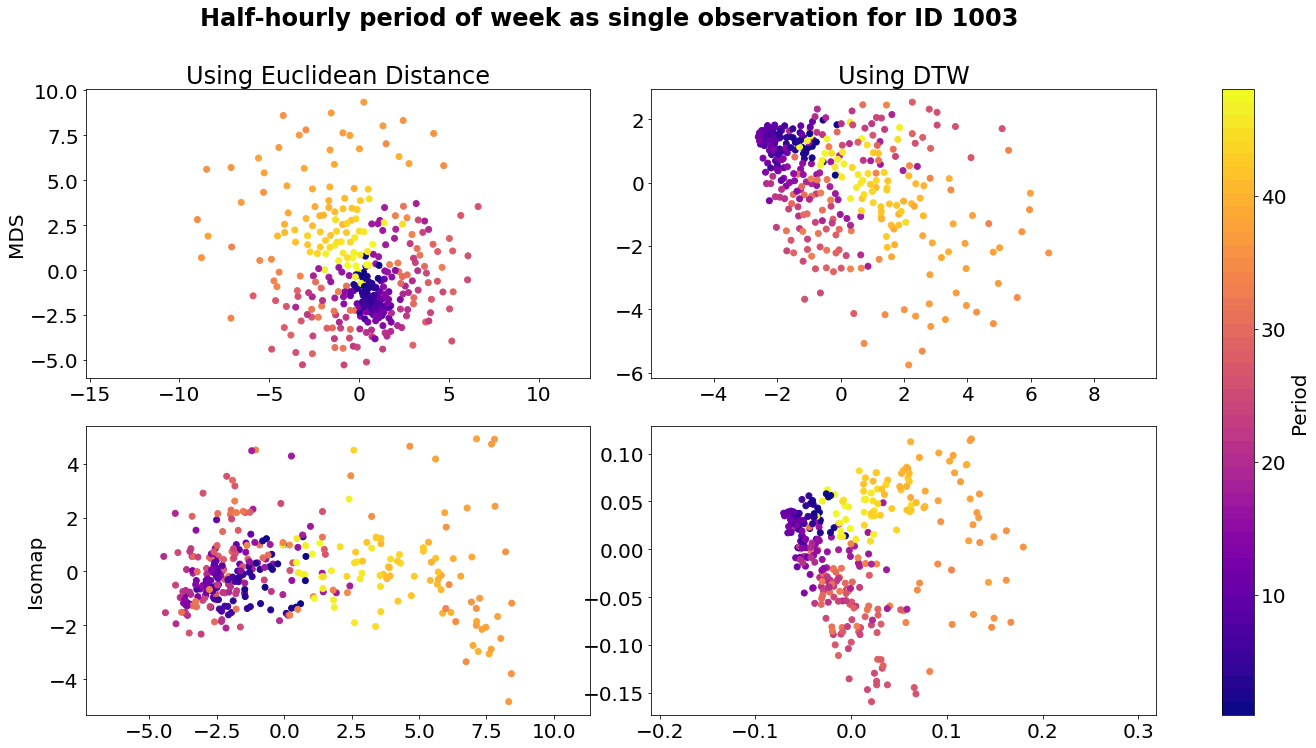

In [210]:
fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(20, 10))
((ax1, ax2),(ax3, ax4))=axs

ax1.scatter(out_MDS3[:, 0], out_MDS3[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax1.axis('equal')
ax1.set_title("Using Euclidean Distance")
ax1.set_ylabel("MDS")

ax2.scatter(out_MDS40[:, 0], out_MDS40[:, 1],c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax2.axis('equal')
ax2.set_title("Using DTW")

ax3.scatter(out_Isomap3[:, 0], out_Isomap3[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax3.axis('equal')
ax3.set_ylabel("Isomap")

im = ax4.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax4.axis('equal')

plt.tight_layout()

fig.colorbar(im,ax=axs,label='Period')
fig.suptitle("Half-hourly period of week as single observation for ID 1003",x=0.42,y=1.05,fontweight="bold")

plt.axis('equal')

plt.show()
fig.savefig('1003period.png',bbox_inches='tight')

### Comparison

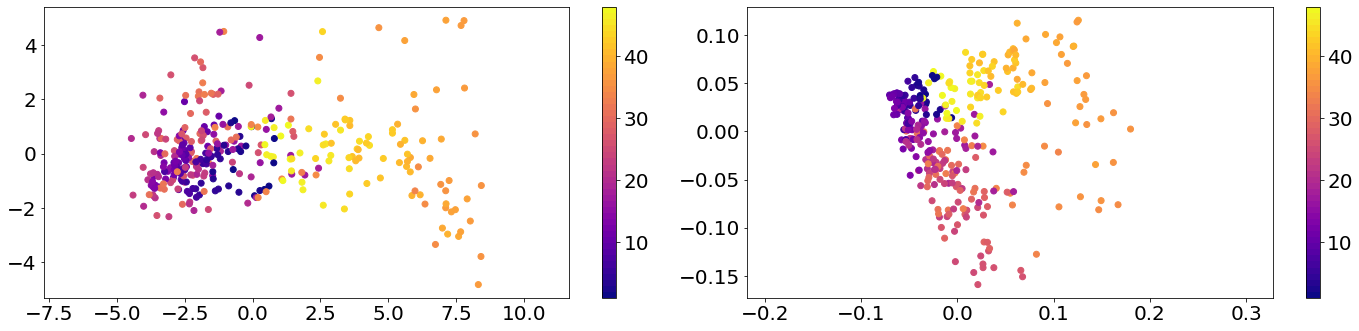

In [144]:
plt.figure(figsize=(20,5))
plt.subplot(1, 2, 1)
plt.scatter(out_Isomap3[:, 0], out_Isomap3[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.subplot(1, 2, 2)
plt.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
plt.colorbar()
plt.axis('equal')

plt.tight_layout()

In [145]:
df_iso40 = array_to_pd(scratch_Isomap40)
fig = px.scatter(df_iso40, x="x", y="y",hover_data=[df_iso40.index],color=color_arr3,
                )
fig.update_yaxes(
    scaleanchor = "x",
    scaleratio = 1,
  )
fig.show()

In [146]:
df2[df2.index==41]

dow  period  tow                                             demand
41    1      42   42  [0.571, 0.566, 1.515, 1.313, 0.561, 0.593, 0.6...

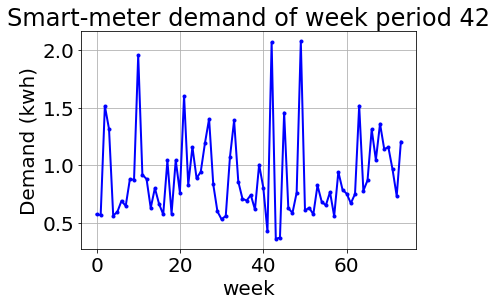

In [147]:
plt.plot(dd_arr2[41], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('week')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of week period '+str(df2.tow[41]))
plt.grid()
plt.show()

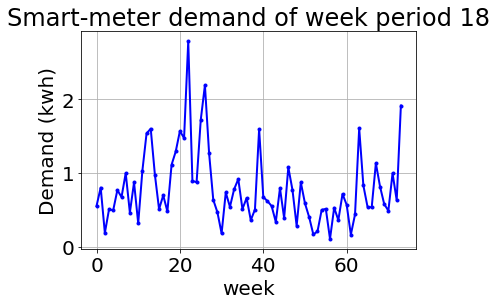

In [148]:
plt.plot(dd_arr2[17], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('week')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of week period '+str(df2.tow[17]))
plt.grid()
plt.show()

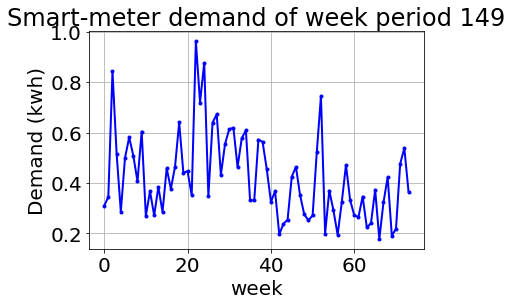

In [149]:
plt.plot(dd_arr2[148], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('week')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of week period '+str(df2.tow[148]))
plt.grid()
plt.show()

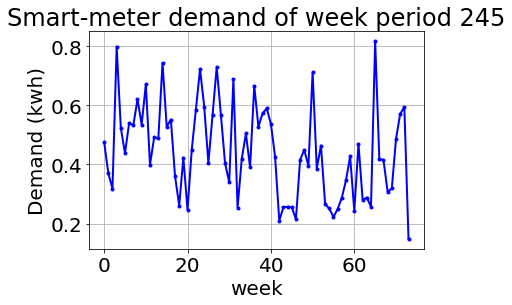

In [150]:
plt.plot(dd_arr2[244], color='blue', marker='o', markersize=3, linewidth=2)
plt.xlabel('week')
plt.ylabel('Demand (kwh)')
plt.title('Smart-meter demand of week period '+str(df2.tow[244]))
plt.grid()
plt.show()

## Sensitivity analysis for DTW

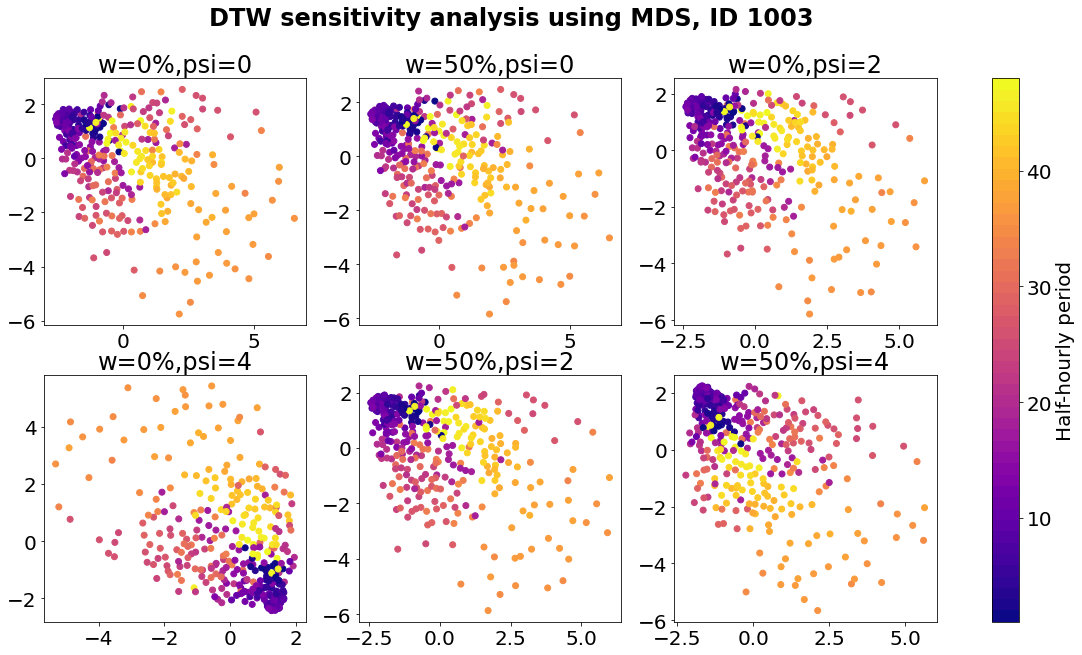

In [45]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
((ax1, ax2,ax3),(ax4,ax5,ax6))=axs
ax1.scatter(out_MDS40[:, 0], out_MDS40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax1.set_title("w=0%,psi=0")

ax2.scatter(out_MDS41[:, 0], out_MDS41[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax2.set_title("w=50%,psi=0")

ax3.scatter(out_MDS42[:, 0], out_MDS42[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax3.set_title("w=0%,psi=2")

ax4.scatter(out_MDS43[:, 0], out_MDS43[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax4.set_title("w=0%,psi=4")

ax5.scatter(out_MDS44[:, 0], out_MDS44[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax5.set_title("w=50%,psi=2")

im = ax6.scatter(out_MDS45[:, 0], out_MDS45[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax6.set_title("w=50%,psi=4")

fig.colorbar(im,ax=axs,label='Half-hourly period')
fig.suptitle("DTW sensitivity analysis using MDS, ID 1003",x=0.45,fontweight="bold")

plt.show()
fig.savefig('1003sensitivityMDS.png')

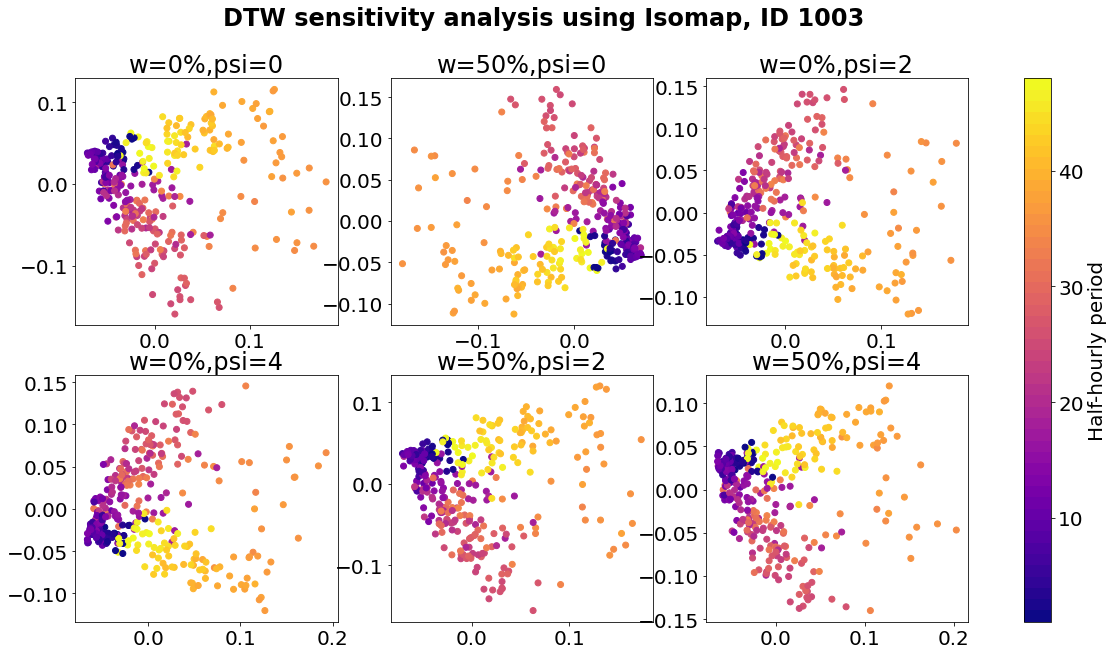

In [42]:
fig, axs = plt.subplots(nrows=2, ncols=3, figsize=(20, 10))
((ax1, ax2,ax3),(ax4,ax5,ax6))=axs
ax1.scatter(scratch_Isomap40[:, 0], scratch_Isomap40[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax1.set_title("w=0%,psi=0")

ax2.scatter(scratch_Isomap41[:, 0], scratch_Isomap41[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax2.set_title("w=50%,psi=0")

ax3.scatter(scratch_Isomap42[:, 0], scratch_Isomap42[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax3.set_title("w=0%,psi=2")

ax4.scatter(scratch_Isomap43[:, 0], scratch_Isomap43[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax4.set_title("w=0%,psi=4")

ax5.scatter(scratch_Isomap44[:, 0], scratch_Isomap44[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax5.set_title("w=50%,psi=2")

im = ax6.scatter(scratch_Isomap45[:, 0], scratch_Isomap45[:, 1], c=color_arr3, cmap=plt.cm.get_cmap('plasma', 48))
ax6.set_title("w=50%,psi=4")

fig.colorbar(im,ax=axs,label='Half-hourly period')
fig.suptitle("DTW sensitivity analysis using Isomap, ID 1003",x=0.45,fontweight="bold")

plt.show()
fig.savefig('1003sensitivity.png')

In [153]:
# from plotly.subplots import make_subplots
# import plotly.graph_objects as go
# import plotly.express as px

# fig = make_subplots(
#     rows=2, cols=3,
#     subplot_titles=("w=100%,psi=0", "w=50%,psi=0", "w=100%,psi=2", "w=100%,psi=4","w=50%,psi=2","w=50%,psi=4"))

# seq_color1 = list(map(str, color_arr1))
# map_color ={"1":"blue",
#             "2":"royalblue",
#             "3":"darkgreen",
#             "4":"forestgreen",
#             "5":"limegreen",
#             "6":"lemonchiffon",
#             "7":"khaki",
#             "8":"gold",          
#             "9":"orangered",          
#             "10":"red",
#             "11":"darkred",
#             '12':"darkblue"}

# fig.add_trace(go.Scatter(x=out_MDS20[:, 0], y=out_MDS20[:, 1],color=seq_color1,
#               color_discrete_map=map_color),
#               row=1, col=1)

# fig.add_trace(go.Scatter(x=out_MDS21[:, 0], y=out_MDS21[:, 1],color=seq_color1,
#               color_discrete_map=map_color),
#               row=1, col=2)

# fig.add_trace(go.Scatter(x=out_MDS22[:, 0], y=out_MDS22[:, 1],color=seq_color1,
#               color_discrete_map=map_color),
#               row=1, col=3)

# fig.add_trace(go.Scatter(x=out_MDS23[:, 0], y=out_MDS23[:, 1],color=seq_color1,
#               color_discrete_map=map_color),
#               row=2, col=1)

# fig.add_trace(go.Scatter(x=out_MDS24[:, 0], y=out_MDS24[:, 1],color=seq_color1,
#               color_discrete_map=map_color),
#               row=2, col=2)

# ig.add_trace(go.Scatter(x=out_MDS25[:, 0], y=out_MDS25[:, 1],color=seq_color1,
#               color_discrete_map=map_color),
#               row=2, col=3)

# fig.update_layout(height=500, width=700,
#                   title_text="MDS mapping using DTW distance with different parameters")

# fig.show()

# Two households

In [154]:
df.groupby(['id','week','day','date','dow']).demand.apply(np.array).reset_index()

id  week  day       date  dow  \
0    1003     1  201 2009-07-20    1   
1    1003     1  202 2009-07-21    2   
2    1003     1  203 2009-07-22    3   
3    1003     1  204 2009-07-23    4   
4    1003     1  205 2009-07-24    5   
..    ...   ...  ...        ...  ...   
513  1003    75  721 2010-12-22    3   
514  1003    75  722 2010-12-23    4   
515  1003    75  723 2010-12-24    5   
516  1003    75  724 2010-12-25    6   
517  1003    75  725 2010-12-26    7   

                                                demand  
0    [0.396, 0.397, 0.378, 0.288, 0.335, 0.407, 0.3...  
1    [0.509, 0.594, 0.629, 0.64, 0.593, 0.499, 0.5,...  
2    [0.83, 1.078, 0.51, 0.314, 0.355, 0.42, 0.421,...  
3    [0.551, 0.541, 0.532, 0.356, 0.309, 0.33, 0.43...  
4    [0.409, 0.443, 0.531, 0.528, 0.443, 0.402, 0.4...  
..                                                 ...  
513  [0.75, 0.916, 0.658, 0.33, 0.441, 0.457, 0.342...  
514  [0.897, 0.526, 0.336, 0.206, 0.366, 0.247, 0.3...  
515  [0.848, 0.871, 0.851, 1.018, 0.883, 0.867, 0.6...  
516  [0.37, 0.352, 0.241, 0.212, 0.148, 0.16, 0.212...  
517  [0.652, 0.718, 0.632, 0.319, 0.325, 0.448, 0.3...  

[518 rows x 6 columns]

In [169]:
df3_z_scaled = df.copy()
column = 'demand'
df3_z_scaled[column] = (df3_z_scaled[column] - df3_z_scaled[column].mean()) / df3_z_scaled[column].std()    
df3_z_scaled

id    demand  day  period       date  dow  tow  month  week
26014  1003 -0.491808  201       1 2009-07-20    1    1      7     1
26015  1003 -0.489724  201       2 2009-07-20    1    2      7     1
26016  1003 -0.529327  201       3 2009-07-20    1    3      7     1
26017  1003 -0.716924  201       4 2009-07-20    1    4      7     1
26018  1003 -0.618957  201       5 2009-07-20    1    5      7     1
...     ...       ...  ...     ...        ...  ...  ...    ...   ...
51207  1003  0.250239  725      44 2010-12-26    7  332     12    75
51208  1003  0.606671  725      45 2010-12-26    7  333     12    75
51209  1003  0.485776  725      46 2010-12-26    7  334     12    75
51210  1003  0.043883  725      47 2010-12-26    7  335     12    75
51211  1003 -0.247933  725      48 2010-12-26    7  336     12    75

[24864 rows x 9 columns]

In [170]:
df3 = df3_z_scaled.groupby(['id','week']).demand.apply(np.array).reset_index()
df3

id  week                                             demand
0   1003     1  [-0.4918082302682789, -0.4897238292635055, -0....
1   1003     2  [0.33153016661721474, 0.33361456762198816, 0.3...
2   1003     3  [-0.39175698203915565, -0.5501714584019343, -0...
3   1003     4  [0.22105691336422437, -0.04157761323722424, -0...
4   1003     5  [-0.2500177137145643, -0.24376451070024413, -0...
..   ...   ...                                                ...
69  1003    71  [-0.5418338543828406, -0.45012021017281095, -0...
70  1003    72  [-0.4563734131871312, -0.6106190875403628, -0....
71  1003    73  [0.7609167736005354, 0.7609167736005354, -0.34...
72  1003    74  [-0.17914807955226864, -0.43552940313939714, -...
73  1003    75  [-0.5689310674448949, -0.23542690668115054, -0...

[74 rows x 3 columns]

In [156]:
df3.demand[0][1::48]

array([0.397, 0.594, 1.078, 0.541, 0.443, 0.6  , 0.549])

In [163]:
hh = data[(data.id == 1077)]
hh['date'] = pd.to_datetime(hh['date'], format='%d-%m-%y')
hh.drop(hh[hh.day==452].index, inplace=True)
hh.drop(hh[hh.week==0].index, inplace=True) # first week started on day 201
hh.drop(hh[hh.week==36].index, inplace=True)# for now delete the week which contains day 452
hh.drop(hh[hh.week==76].index, inplace=True) # last week is week 75

In [171]:
hh2_z_scaled = hh.copy()
column = 'demand'
hh2_z_scaled[column] = (hh2_z_scaled[column] - hh2_z_scaled[column].mean()) / hh2_z_scaled[column].std()    
hh2 = hh2_z_scaled.groupby(['id','week']).demand.apply(np.array).reset_index()
hh2

id  week                                             demand
0   1077     1  [-0.7604460954506109, -0.5643952895533378, -0....
1   1077     2  [-0.22995567949328408, -0.25686461363604707, -...
2   1077     3  [-0.22611154604431793, -0.6412779585326607, -0...
3   1077     4  [-0.07619034153463872, -0.06081380773877416, 0...
4   1077     5  [-0.32221488226847134, -0.22611154604431793, -...
..   ...   ...                                                ...
69  1077    71  [-0.1030992756774017, -0.13000820982016445, -0...
70  1077    72  [-0.43369475228848925, -0.568239423002304, -0....
71  1077    73  [-0.5836159567981686, -0.5297980885126428, -0....
72  1077    74  [-0.14538474361602902, -0.14154061016706287, -...
73  1077    75  [-0.29530594812570843, -0.2914618146767423, -0...

[74 rows x 3 columns]

In [172]:
df_combined = pd.concat([df3, hh2], ignore_index=True)

In [181]:
dd_v3 = df_combined['demand'].to_numpy()
dd_arr3 = np.vstack(dd_v3)
print(dd_arr3.shape)
color_arr4 = df_combined['id'].to_numpy() # map to week
print(color_arr4.shape)

(148, 336)
(148,)


In [174]:
dtw_matrix30 = dtw.distance_matrix_fast(dd_arr3)

(-28.922097723443972,
 24.763511623682945,
 -22.623981083754703,
 31.48915910782552)

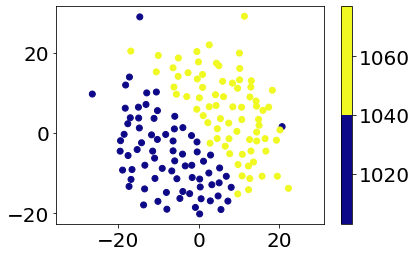

In [184]:
model_MDS = MDS(n_components=2, random_state=1)
out_MDS5 = model_MDS.fit_transform(dd_arr3)
plt.scatter(out_MDS5[:, 0], out_MDS5[:, 1],c=color_arr4, cmap=plt.cm.get_cmap('plasma', 2))
plt.colorbar()
plt.axis('equal')

(-14.232860288299905,
 10.834506549029479,
 -10.051746229411163,
 15.51239278742913)

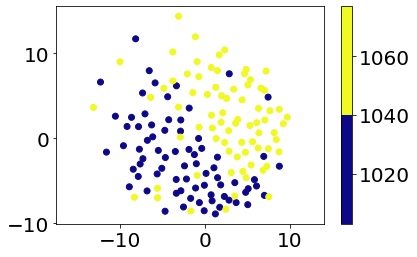

In [185]:
model_MDS = MDS(n_components=2,dissimilarity='precomputed', random_state=1)
out_MDS60 = model_MDS.fit_transform(dtw_matrix30)
plt.scatter(out_MDS60[:, 0], out_MDS60[:, 1],c=color_arr4, cmap=plt.cm.get_cmap('plasma',2))
plt.colorbar()
plt.axis('equal')

(-22.382703132938715, 37.88787292966142, -16.24213332832036, 28.69866374421916)

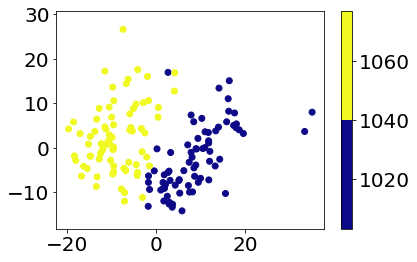

In [186]:
model_Isomap = Isomap(n_neighbors=20, n_components=2, eigen_solver='dense')
out_Isomap5 = model_Isomap.fit_transform(dd_arr3)

plt.scatter(out_Isomap5[:, 0], out_Isomap5[:, 1], c=color_arr4, cmap=plt.cm.get_cmap('plasma', 2))
plt.colorbar()
plt.axis('equal')

(-0.3352789917910623,
 0.1971581845979749,
 -0.30999085132109505,
 0.2406081668724091)

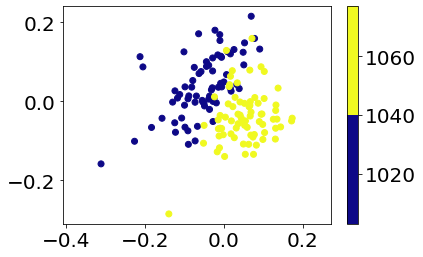

In [187]:
scratch_Isomap60 = isomap(dd_arr3,n_neighbors=20)
plt.scatter(scratch_Isomap60[:, 0], scratch_Isomap60[:, 1], c=color_arr4, cmap=plt.cm.get_cmap('plasma', 2))
plt.colorbar()
plt.axis('equal')

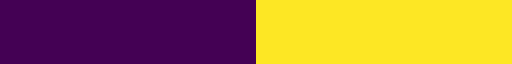

In [188]:
plt.cm.get_cmap('viridis',2)

In [189]:
import seaborn as sns
sns.color_palette("Set2", 8)

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]

In [192]:
rgb = sns.color_palette("Set2", 8)

In [193]:
rgb

[(0.4, 0.7607843137254902, 0.6470588235294118),
 (0.9882352941176471, 0.5529411764705883, 0.3843137254901961),
 (0.5529411764705883, 0.6274509803921569, 0.796078431372549),
 (0.9058823529411765, 0.5411764705882353, 0.7647058823529411),
 (0.6509803921568628, 0.8470588235294118, 0.32941176470588235),
 (1.0, 0.8509803921568627, 0.1843137254901961),
 (0.8980392156862745, 0.7686274509803922, 0.5803921568627451),
 (0.7019607843137254, 0.7019607843137254, 0.7019607843137254)]